In [1]:
# Import required libraries
from segmentation_pipeline import nnUNet, nnUNetConfidence
from lungmask import LMInferer
from segmentation_pipeline import pydicom_to_nifti
from segmentation_pipeline import apply_windowing
from segmentation_pipeline import random_pad_3d_box
import torch
import torch.nn.functional as F
import cc3d
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
import os
from pathlib import Path
import ants
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# torch.cuda.set_device(0) 

/afs/csail.mit.edu/u/b/bgrey/DiffusionEvalPipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
def get_dicom_files_with_slice_locations(directory_path):
    """
    Loop through all DICOM files in a directory and extract their paths and slice locations.
    
    Args:
        directory_path (str): Path to the directory containing DICOM files
        
    Returns:
        tuple: (list of file paths, list of corresponding slice locations)
    """
    dicom_paths = []
    slice_locations = []
    
    # Convert to Path object for easier handling
    dir_path = Path(directory_path)
    
    # Check if directory exists
    if not dir_path.exists():
        raise ValueError(f"Directory does not exist: {directory_path}")
    
    # Loop through all files in directory (including subdirectories)
    for file_path in dir_path.rglob('*'):
        # Skip directories
        if file_path.is_dir():
            continue
            
        try:
            # Try to read as DICOM file
            dcm = pydicom.dcmread(str(file_path), stop_before_pixels=True)
            
            # Check if SliceLocation exists in metadata
            if hasattr(dcm, 'Slice Location'):
                dicom_paths.append(str(file_path))
                slice_locations.append(float(dcm['Slice Location'].value))
            elif hasattr(dcm, 'ImagePositionPatient'):
                # Alternative: use Z coordinate from ImagePositionPatient if SliceLocation not available
                dicom_paths.append(str(file_path))
                slice_locations.append(float(dcm.ImagePositionPatient[2]))
        except Exception as e:
            # Skip files that are not valid DICOM files
            continue
    
    return dicom_paths, slice_locations

In [3]:
def order_slices(img_paths, slice_locations, reverse=False):
    sorted_ids = np.argsort(slice_locations)
    if reverse:
        sorted_ids = sorted_ids[::-1]
    sorted_img_paths = np.array(img_paths)[sorted_ids].tolist()
    sorted_slice_locs = np.sort(slice_locations).tolist()

    return sorted_img_paths, sorted_slice_locs

## Load Models

In [4]:
# Load segmentation model checkpoint
segmentation_model_checkpoint = torch.load(
    "/data/rbg/scratch/lung_ct/checkpoints/5678b14bb8a563a32f448d19a7d12e6b/last.ckpt",
    weights_only=False
)

new_segmentation_model_state_dict = {}
for k, v in segmentation_model_checkpoint["state_dict"].items():
    if "classifier" not in k:
        new_k = k.replace("model.model", "model")  
        new_segmentation_model_state_dict[new_k] = v

In [5]:
# Load confidence model checkpoint
confidence_model_checkpoint = torch.load(
    "/data/rbg/scratch/lung_ct/checkpoints/4296b4b6cda063e96d52aabfb0694a04/4296b4b6cda063e96d52aabfb0694a04epoch=9.ckpt",
    weights_only=False
)

new_confidence_model_state_dict = {}
for k, v in confidence_model_checkpoint["state_dict"].items():
    new_k = k.replace("model.model", "model")  
    if "model.classifier" in new_k:
        new_k = new_k.replace("model.classifier", "classifier")
    new_confidence_model_state_dict[new_k] = v

In [6]:
# Initialize models
segmentation_model = nnUNet(
    segmentation_model_checkpoint["hyper_parameters"]["args"]
)
segmentation_model.load_state_dict(new_segmentation_model_state_dict)

confidence_model = nnUNetConfidence(
    confidence_model_checkpoint["hyper_parameters"]["args"]
)
confidence_model.load_state_dict(new_confidence_model_state_dict)

# Load lungmask model
model = LMInferer(
    modelpath="/data/rbg/users/pgmikhael/current/lungmask/checkpoints/unet_r231-d5d2fc3d.pth",
    tqdm_disable=True,
    batch_size=100,
    force_cpu=False,
)

# Set to eval mode
segmentation_model.eval()
confidence_model.eval()

nnUNetConfidence(
  (model): ResidualEncoder(
    (stem): StackedConvBlocks(
      (convs): Sequential(
        (0): ConvDropoutNormReLU(
          (conv): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (norm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
          (all_modules): Sequential(
            (0): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
    )
    (stages): Sequential(
      (0): StackedResidualBlocks(
        (blocks): Sequential(
          (0): BasicBlockD(
            (conv1): ConvDropoutNormReLU(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (norm

## Load Image Data

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Option 1: Load from DICOM directory (commented out)
# dicom_dir = "/data/rbg/shared/datasets/NLST/NLST/all_nlst-ct/set2/batch1/102676/T0/1.2.840.113654.2.55.106468547949258489874106374248199128625/"
# dicom_dir = "/data/rbg/shared/datasets/NLST/NLST/all_nlst-ct/set2/batch2/208089/T2/1.3.6.1.4.1.14519.5.2.1.7009.9004.249204139349143430936217412730/"
# img_paths, slice_locations = get_dicom_files_with_slice_locations(dicom_dir)
# sorted_img_paths, sorted_slice_locs = order_slices(img_paths, slice_locations, reverse=False)
# depth = len(sorted_img_paths)
# # sorted_img_paths = sorted_img_paths[depth//2 - 10: depth//2 + 10]
# print(f"Number of slices found: {len(sorted_img_paths)}")
# image = pydicom_to_nifti(
#     sorted_img_paths,
#     return_nifti=False, save_nifti=False,
#     output_path="buffer",
# )
# print(f"Original image shape: {image.shape}, dtype: {image.dtype}")
# print(f"Unique values in original image: {np.unique(image)}")

# # Option 2: Load from numpy file
# voxel_spacing = [0.8, 0.8, 1.5]  # y, x, z
# affine = torch.diag(torch.tensor(voxel_spacing + [1]))

# image = np.load("image_array_depth20.npy")
# print(f"Image shape: {image.shape}, dtype: {image.dtype}")
# print(f"Original image type: {type(image)}, shape: {image.shape}")

# load .pt file as tensor
# tensor = torch.load("test_tensor2.pt").squeeze(0)
# image = np.array(tensor)
# print(f"Image shape: {tensor.shape}, dtype: {tensor.dtype}")
# # print unique values in image
# print(f"Unique values in image: {np.unique(image)}")

nifti_path = "/data/rbg/scratch/lung_ct/nlst_nifti/sample_10000402215824639.nii.gz"
ants_image = ants.image_read(nifti_path)
pixel_spacing = ants_image.spacing
print(f"Pixel spacing: {pixel_spacing}")
image = ants_image.numpy()
image = np.transpose(image, (2, 1, 0))  # Convert from x,y,z to z,y,x
print(f"Image shape: {image.shape}, dtype: {image.dtype}")




Pixel spacing: (0.8007810115814209, 0.8007810115814209, 2.5)
Image shape: (118, 512, 512), dtype: float32


In [24]:
# Extract middle slice from lung tensor and save it to visualize
# mid_slice_idx = image.shape[0] // 2
# print(f"Image shape before slicing: {image.shape}")
# image = image[150, :, :][None, :, :]
# slice_img = Image.fromarray(slice).convert("L")
# plt.imsave("slice.png", slice, cmap='gray')

In [25]:
# lung_mask = model.apply(image)
# print(f"Lung mask shape: {lung_mask.shape}")
# plt.imsave("lung_mask_slice.png", lung_mask[0], cmap='gray')

## Generate Lung Mask

lungmask 2025-12-16 10:38:22 Postprocessing
Lung mask shape: (118, 512, 512)
Lung mask unique values: [0 1]


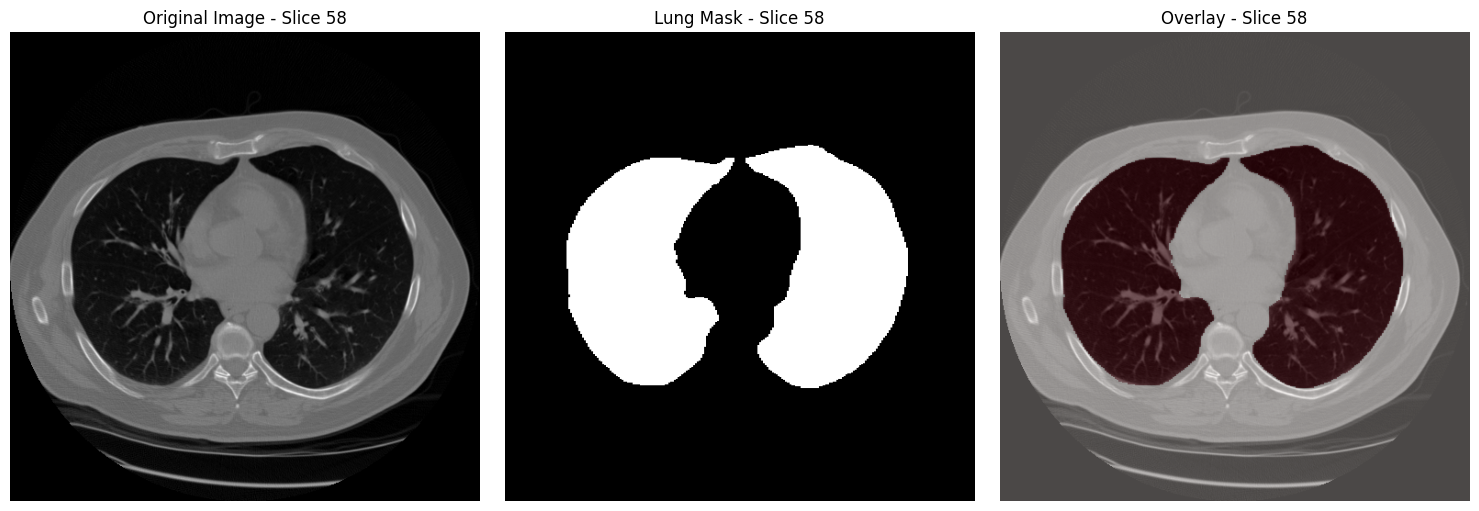

Slice with most non-zero values: 58
Number of non-zero pixels in that slice: 59243


In [26]:
# Run lung mask - transpose to put depth first
# image_ = np.transpose(image, (2, 1, 0))
# note lungmask model expects shape (D, H, W), no batch dimension
lung_mask = model.apply(image)
lung_mask = (lung_mask > 0).astype(np.uint8)
print(f"Lung mask shape: {lung_mask.shape}")
print(f"Lung mask unique values: {np.unique(lung_mask)}")
# Visualize the slice with most non-zero values
non_zero_counts_per_slice = (lung_mask > 0).sum(axis=(1, 2))
max_nonzero_slice_idx = np.argmax(non_zero_counts_per_slice)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image[max_nonzero_slice_idx, :, :], cmap='gray')
plt.title(f'Original Image - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lung_mask[max_nonzero_slice_idx], cmap='gray')
plt.title(f'Lung Mask - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image[max_nonzero_slice_idx, :, :], cmap='gray')
plt.imshow(lung_mask[max_nonzero_slice_idx], cmap='Reds', alpha=0.3)
plt.title(f'Overlay - Slice {max_nonzero_slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Slice with most non-zero values: {max_nonzero_slice_idx}")
print(f"Number of non-zero pixels in that slice: {non_zero_counts_per_slice[max_nonzero_slice_idx]}")

# mid_slice = lung_mask.shape[0] // 2

## Preprocess Image

In [27]:
# Apply windowing
image = apply_windowing(image.astype(np.float64), -600, 1600)
# print(f"image type after windowing: {type(image)}, shape: {image.shape}")

# Convert to tensor and normalize
image = torch.tensor(image) // 256
image = image.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, D, H, W]
# image = image.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, D, H, W]
print(f"Image shape after unsqueezes: {image.shape}")

# Interpolate to target size
# image = F.interpolate(
#     image,
#     size=(image.shape[2], 1024, 1024),
#     mode="trilinear",
#     align_corners=False,
# )
image = image.squeeze(1)
image = image[None]
print(f"Image shape after interpolation: {image.shape}")

Image shape after unsqueezes: torch.Size([1, 1, 118, 512, 512])
Image shape after interpolation: torch.Size([1, 1, 118, 512, 512])


## Run Segmentation Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentation_model = segmentation_model.to(device)
image = image.to(device)

# Run segmentation
with torch.no_grad():
    segmentation_outputs = segmentation_model.predict(image.float()).cpu()

print(f"Segmentation output shape: {segmentation_outputs.shape}")

print(f"segmentation unique values: {torch.unique(segmentation_outputs)}")

# Create binary segmentation
binary_segmentation = (
    1 * (F.softmax(segmentation_outputs, 1)[0, 1] > 0.5) * lung_mask
)
print(f"Binary segmentation shape: {binary_segmentation.shape}")

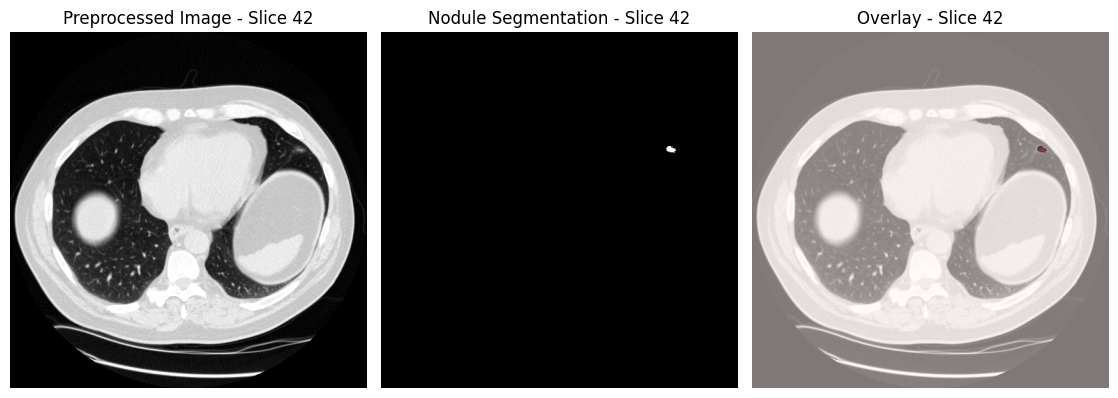

Slice with most nodule pixels: 42
Number of nodule pixels in that slice: 88


In [ ]:
# Visualize slice with most nodule pixels
non_zero_counts_per_slice = (binary_segmentation > 0).sum(axis=(1, 2))
max_nodule_slice_idx = np.argmax(non_zero_counts_per_slice)


plt.figure(figsize=(15, 5))


# Preprocessed image slice
plt.subplot(1, 4, 1)
plt.imshow(image.cpu().squeeze()[max_nodule_slice_idx, :, :], cmap='gray')
plt.title(f'Preprocessed Image - Slice {max_nodule_slice_idx}')
plt.axis('off')

# Binary segmentation
plt.subplot(1, 4, 2)
plt.imshow(binary_segmentation[max_nodule_slice_idx], cmap='gray')
plt.title(f'Nodule Segmentation - Slice {max_nodule_slice_idx}')
plt.axis('off')

# Overlay on original
plt.subplot(1, 4, 3)
plt.imshow(image.cpu().squeeze()[max_nodule_slice_idx, :, :], cmap='gray')
plt.imshow(binary_segmentation[max_nodule_slice_idx], cmap='Reds', alpha=0.5)
plt.title(f'Overlay - Slice {max_nodule_slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Slice with most nodule pixels: {max_nodule_slice_idx}")
print(f"Number of nodule pixels in that slice: {non_zero_counts_per_slice[max_nodule_slice_idx]}")


In [ ]:
# Get combined volume of nodule pixels 
nodule_pixel_count = (binary_segmentation > 0).sum().item()
print(f"Total nodule pixel count: {nodule_pixel_count}")
pixel_volume = pixel_spacing[0] * pixel_spacing[1] * pixel_spacing[2]
nodule_volume = nodule_pixel_count * pixel_volume
print(f"Nodule volume : {nodule_volume}")

Total nodule pixel count: 334
Nodule volume : 535.4439408053188


## Extract Connected Components

In [ ]:
# Get connected components
instance_segmentation, num_instances = cc3d.connected_components(
    binary_segmentation.cpu().numpy(),
    return_N=True,
)
# Get unique values from instance segmentation
unique_vals = np.unique(instance_segmentation)
print(f"Unique instance values: {unique_vals}")
print(f"Number of instances found: {num_instances}")
print(f"Instance segmentation shape: {instance_segmentation.shape}")

# Convert to sparse tensor
sparse_segmentation = torch.tensor(instance_segmentation, dtype=torch.int32).to_sparse()
print(f"Sparse segmentation indices shape: {sparse_segmentation.indices().shape}")

Unique instance values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Number of instances found: 13
Instance segmentation shape: (118, 512, 512)
Sparse segmentation indices shape: torch.Size([3, 334])


In [ ]:
# For each instance compute volume and pixel count
nodule_volumes = {}
for instance_id in range(1, num_instances + 1):
    instance_mask = (instance_segmentation == instance_id)
    instance_pixel_count = instance_mask.sum()
    instance_volume = instance_pixel_count * pixel_volume
    print(f"Instance {instance_id}: Pixel Count = {instance_pixel_count}, Volume = {instance_volume}")
    nodule_volumes[instance_id] = instance_volume

Instance 1: Pixel Count = 168, Volume = 269.3250959739328
Instance 2: Pixel Count = 1, Volume = 1.6031255712734094
Instance 3: Pixel Count = 122, Volume = 195.58131969535594
Instance 4: Pixel Count = 3, Volume = 4.809376713820228
Instance 5: Pixel Count = 7, Volume = 11.221878998913866
Instance 6: Pixel Count = 1, Volume = 1.6031255712734094
Instance 7: Pixel Count = 4, Volume = 6.4125022850936375
Instance 8: Pixel Count = 2, Volume = 3.2062511425468188
Instance 9: Pixel Count = 1, Volume = 1.6031255712734094
Instance 10: Pixel Count = 1, Volume = 1.6031255712734094
Instance 11: Pixel Count = 19, Volume = 30.459385854194778
Instance 12: Pixel Count = 1, Volume = 1.6031255712734094
Instance 13: Pixel Count = 4, Volume = 6.4125022850936375


In [ ]:
# Reshape image for patch extraction
image_ = image.squeeze(0).squeeze(0).permute(1, 2, 0)  # shape: H, W, D
print(f"Image shape: {image_.shape}")

Image shape: torch.Size([512, 512, 118])


## Extract Patches for Each Instance

In [ ]:
patches = []
patch_sizes = []  # Track sizes to determine max dimensions
# temp_patches = []

# First pass: extract patches and track sizes
for inst_id in range(1, num_instances + 1):
    zs, ys, xs = sparse_segmentation.indices()[
        :, sparse_segmentation.values() == inst_id
    ]
    box = {
        "x_start": torch.min(xs).item(),
        "x_stop": torch.max(xs).item(),
        "y_start": torch.min(ys).item(),
        "y_stop": torch.max(ys).item(),
        "z_start": torch.min(zs).item(),
        "z_stop": torch.max(zs).item(),
    }
    # print ranges of the box
    # print(f"Instance {inst_id}: x({box['x_start']}, {box['x_stop']}), "
    #       f"y({box['y_start']}, {box['y_stop']}), "
    #       f"z({box['z_start']}, {box['z_stop']})")
    patch = torch.zeros_like(image_)
    print(f"patch shape: {patch.shape}")
    patch[
        box["y_start"] : box["y_stop"] + 1,
        box["x_start"] : box["x_stop"] + 1,
        box["z_start"] : box["z_stop"] + 1,
    ] = binary_segmentation[
        box["z_start"] : box["z_stop"] + 1,
        box["y_start"] : box["y_stop"] + 1,
        box["x_start"] : box["x_stop"] + 1,
    ].permute(1, 2, 0)
    cbbox = random_pad_3d_box(
        box,
        image_,
        min_height=128,
        min_width=128,
        min_depth=32,  # Increased to 32 to ensure enough depth for network layers
        random_hw=False,
        random_d=False,
    )
    patchx = image_[cbbox]
    patchl = patch[cbbox]
    print(f"patchx shape: {patchx.shape}, patchl shape: {patchl.shape}")
    patches.append(torch.stack([patchx, patchl]))
    patch_sizes.append(patchx.shape)

print(f"Extracted {len(patches)} patches.")
patches = torch.stack(patches)
print(f"Stacked patches shape: {patches.shape}")

patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch shape: torch.Size([512, 512, 118])
patchx shape: torch.Size([128, 128, 32]), patchl shape: torch.Size([128, 128, 32])
patch sh

In [ ]:
# save the tensors of the image patches
image_patches = patches[:, 0, :, :, :]  # shape: [N, H, W, D]
image_patches = image_patches.permute(0, 3, 1, 2)  # shape: [N, D, H, W]
print(f"Image patches shape: {image_patches.shape}")
torch.save(
    image_patches,
    "nodule_patches_sample_10000402215824639.pt",
)

Image patches shape: torch.Size([13, 32, 128, 128])


## Pad Patches to Uniform Size

## Run Confidence Model

In [ ]:
# Run confidence model
confidence_model = confidence_model.to('cpu')
# patches = torch.stack(patches)
patches = patches.to('cpu').float()
with torch.no_grad():
    confidence_outputs = confidence_model(patches)

# print(f"Confidence outputs shape: {torch.as_tensor(confidence_outputs).shape}")
# print(f"Confidence outputs: {confidence_outputs}")

logits = confidence_outputs['logit']
print(f"Logits shape: {logits.shape}")
# run softmax on logits to get confidence scores
confidence_scores = F.softmax(logits, dim=1)
print(f"confidence scores: {confidence_scores}")

Logits shape: torch.Size([13, 2])
confidence scores: tensor([[0.5374, 0.4626],
        [0.4850, 0.5150],
        [0.7380, 0.2620],
        [0.7583, 0.2417],
        [0.6719, 0.3281],
        [0.7697, 0.2303],
        [0.5939, 0.4061],
        [0.4557, 0.5443],
        [0.6536, 0.3464],
        [0.6380, 0.3620],
        [0.6363, 0.3637],
        [0.6560, 0.3440],
        [0.6225, 0.3775]])


In [ ]:
total_volume = 0
for patch_id, volume in nodule_volumes.items():
    if confidence_scores[patch_id-1, 0] > 0.5:  # Assuming class 1 is the positive class
        total_volume += volume
    print(f"Patch ID: {patch_id}, Volume (mm^3): {volume}, Confidence Scores: {confidence_scores[patch_id-1].cpu().numpy()}")

print(f"Total volume of high-confidence patches (mm^3): {total_volume}")

Patch ID: 1, Volume (mm^3): 269.3250959739328, Confidence Scores: [0.5374142  0.46258575]
Patch ID: 2, Volume (mm^3): 1.6031255712734094, Confidence Scores: [0.48499098 0.5150091 ]
Patch ID: 3, Volume (mm^3): 195.58131969535594, Confidence Scores: [0.7379697  0.26203024]
Patch ID: 4, Volume (mm^3): 4.809376713820228, Confidence Scores: [0.75834405 0.24165595]
Patch ID: 5, Volume (mm^3): 11.221878998913866, Confidence Scores: [0.6719189 0.3280811]
Patch ID: 6, Volume (mm^3): 1.6031255712734094, Confidence Scores: [0.76965976 0.23034018]
Patch ID: 7, Volume (mm^3): 6.4125022850936375, Confidence Scores: [0.5938981  0.40610185]
Patch ID: 8, Volume (mm^3): 3.2062511425468188, Confidence Scores: [0.45572105 0.54427886]
Patch ID: 9, Volume (mm^3): 1.6031255712734094, Confidence Scores: [0.653624   0.34637597]
Patch ID: 10, Volume (mm^3): 1.6031255712734094, Confidence Scores: [0.6380374 0.3619626]
Patch ID: 11, Volume (mm^3): 30.459385854194778, Confidence Scores: [0.6363046  0.36369538]
Pat

In [ ]:
tensor = torch.load("/data/rbg/scratch/lung_ct/nlst_abnormalities51_nnunet_sparse_segmentation/sample_10000402215824639.pt")
print(tensor)
print(tensor["sparse_segmentation"].coalesce().indices().shape)
print(tensor["sparse_segmentation"].coalesce().values().shape)
print(f"unique values in sparse segmentation: {torch.unique(tensor['sparse_segmentation'].coalesce().values())}")
# get total volume from sparse segmentation
volume_total = sum(tensor["nodule_volumes"])
print(f"Total volume from sparse segmentation (mm^3): {volume_total}")


{'sparse_segmentation': tensor(indices=tensor([[338, 338, 338,  ..., 709, 709, 709],
                       [828, 832, 833,  ..., 352, 353, 353],
                       [ 42,  42,  42,  ...,  93,  92,  93]]),
       values=tensor([ 1.,  1.,  1.,  ..., 14., 14., 14.]),
       size=(1024, 1024, 118), nnz=4667, layout=torch.sparse_coo), 'nodule_ids': tensor([ 1,  2,  3,  4,  9, 11, 12, 13, 14]), 'nodule_cancer_labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'nodule_luna25_labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'nodule_volumes': tensor([ 89.7750,  90.5766, 784.7300, 178.7485, 422.8244, 165.5227,  27.6539,
         19.2375,  91.3782]), 'nodule_has_cancer_labels': tensor([False, False, False, False, False, False, False, False, False]), 'nodule_has_luna25_labels': tensor([False, False, False, False, False, False, False, False, False])}
torch.Size([3, 4667])
torch.Size([4667])
unique values in sparse segmentation: tensor([ 1.,  2.,  3.,  4.,  9., 11., 12., 13., 14.])
Tot